# Importing Libs

In [62]:
import pandas as pd
import numpy as np
import math
import sys
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from mpl_toolkits.axes_grid1 import AxesGrid

plt.style.use('ggplot')
path_project = "/home/igormago/projects/DeepFootball/"
sys.path.insert(1, path_project)
from conf.configparser import conf

# Betting Strategies

In [69]:
countries_abv = {'Brazil A': 'BR1', 'Brazil B': 'BR2', 'England A': 'GB1', 'France A': 'FR1', 'Germany A': 'DE1', 'Italy A':'IT1', 'Netherlands A': 'NL1', 'Portugal A': 'PT1', 'Spain A': 'ES1' }
classifier_abv = {'XGBClassifier': 'XGB', 'GaussianNB': 'GNB', 'LogisticRegression': 'LRE', 'mkc': 'MKC', 'mcc':'MCC'}

def get_abv_list(countries):
    abv = list()
    for c in countries:
        abv.append(countries_abv[c])
        
    return abv

In [70]:
CLASSIFIERS = ['XGBClassifier', 'GaussianNB','LogisticRegression','mkc', 'mcc']
CHAMPIONSHIPS =  ['Brazil A', 'Brazil B', 'England A', 'France A', 'Germany A', 'Italy A', 
                 'Netherlands A', 'Portugal A', 'Spain A']

exp1 = ['performance', 'gw']
exp2 = ['market','gw']
exp3 = ['total', 'gw']
#EXPERIMENTS = [exp1, exp2, exp3]
EXPERIMENTS = [exp1, exp2, exp3]

CHAMPIONSHIP = 'm.ss.ch.nm'
RESULT = 'm.res.bts'
MODEL_PREDICTION = 'pred'
MARKET_PREDICTION = 'm.odds.f.bts.f.c'
MODEL_PROB_Y = 'pred_prob_y'
MODEL_PROB_N = 'pred_prob_n'

Y_ODD_MAX = 'm.odds.s.bts.y.o.max'
N_ODD_MAX = 'm.odds.s.bts.n.o.max'

Y_ODD_AVG = 'm.odds.s.bts.y.o.avg'
N_ODD_AVG = 'm.odds.s.bts.n.o.avg'

Y_PROB_AVG = 'm.odds.s.bts.y.t.avg'
N_PROB_AVG = 'm.odds.s.bts.n.t.avg'

BET_PR_BTS = 'bet.pred.res'
BET_PR_HIT = 'bet.pred.hit'
BET_PR_PL_AVG = 'bet.pred.pl.avg'
BET_PR_PL_MAX = 'bet.pred.pl.max'

BET_EV_BTS = 'bet.ev.res'
BET_EV_VAL_Y_AVG = 'bet.ev.val.y.avg'
BET_EV_VAL_N_AVG = 'bet.ev.val.n.avg'
BET_EV_VAL_Y_MAX = 'bet.ev.val.y.max'
BET_EV_VAL_N_MAX = 'bet.ev.val.n.max'

BET_EV_PL_Y_AVG = 'bet.ev.pl.y.avg'
BET_EV_PL_N_AVG = 'bet.ev.pl.n.avg'
BET_EV_PL_Y_MAX = 'bet.ev.pl.y.max'
BET_EV_PL_N_MAX = 'bet.ev.pl.n.max'

BET_EV_PL_AVG = 'bet.ev.pl.avg'
BET_EV_PL_MAX = 'bet.ev.res.max'

BET_KC_BTS = 'bet.kc.res'

BET_KC_VAL_Y_AVG = 'bet.kc.val.y.avg'
BET_KC_VAL_N_AVG = 'bet.kc.val.n.avg'
BET_KC_VAL_Y_MAX = 'bet.kc.val.y.max'
BET_KC_VAL_N_MAX = 'bet.kc.val.n.max'

BET_KC_PL_Y_AVG = 'bet.kc.pl.y.avg'
BET_KC_PL_N_AVG = 'bet.kc.pl.n.avg'
BET_KC_PL_Y_MAX = 'bet.kc.pl.y.max'
BET_KC_PL_N_MAX = 'bet.kc.pl.n.max'

BET_KC_PL_AVG = 'bet.kc.pl.avg'
BET_KC_PL_MAX = 'bet.kc.pl.max'

In [71]:
def bet_on_predicted(data):
    data[BET_PR_BTS] = data[MODEL_PREDICTION]
    data[BET_PR_HIT] = data[BET_PR_BTS] == data[RESULT]
    data[BET_PR_PL_AVG] = np.where(data[BET_PR_HIT] == True, 
                                   (np.where(data[BET_PR_BTS] == 'y', data[Y_ODD_AVG]-1, data[N_ODD_AVG]-1)), -1)
    
    data[BET_PR_PL_MAX] = np.where(data[BET_PR_HIT] == True, 
                                   (np.where(data[BET_PR_BTS] == 'y', data[Y_ODD_MAX]-1, data[N_ODD_MAX]-1)), -1)

def bet_with_expected_value(data):
    
    data[BET_EV_VAL_Y_AVG] = data[MODEL_PROB_Y]*data[Y_ODD_AVG]-1
    data[BET_EV_VAL_N_AVG] = data[MODEL_PROB_N]*data[N_ODD_AVG]-1
    data[BET_EV_VAL_Y_MAX] = data[MODEL_PROB_Y]*data[Y_ODD_MAX]-1
    data[BET_EV_VAL_N_MAX] = data[MODEL_PROB_N]*data[N_ODD_MAX]-1
    
    data[BET_EV_PL_Y_AVG] = np.where(data[BET_EV_VAL_Y_AVG] > 0, 
                                         (np.where(data[RESULT] == 'y', data[Y_ODD_AVG]-1, -1))
                                    , 0)
    
    data[BET_EV_PL_N_AVG] = np.where(data[BET_EV_VAL_N_AVG] > 0, 
                                         (np.where(data[RESULT] == 'n', data[N_ODD_AVG]-1, -1))
                                    , 0)
        
    data[BET_EV_PL_Y_MAX] = np.where(data[BET_EV_VAL_Y_MAX] > 0, 
                                         (np.where(data[RESULT] == 'y', data[Y_ODD_MAX]-1, -1))
                                     , 0)
        
    data[BET_EV_PL_N_MAX] = np.where(data[BET_EV_VAL_N_MAX] > 0, 
                                         (np.where(data[RESULT] == 'n', data[N_ODD_MAX]-1, -1))
                                     , 0)
    
    data[BET_EV_PL_AVG] = data[BET_EV_PL_Y_AVG] + data[BET_EV_PL_N_AVG]    
    data[BET_EV_PL_MAX] = data[BET_EV_PL_Y_MAX] + data[BET_EV_PL_N_MAX]

def bet_with_kelly_criterion(data):
    
    data[BET_KC_VAL_Y_AVG] = ((data[Y_ODD_AVG]-1)*data[MODEL_PROB_Y]-data[MODEL_PROB_N])/(data[Y_ODD_AVG]-1)
    data[BET_KC_VAL_N_AVG] = ((data[N_ODD_AVG]-1)*data[MODEL_PROB_N]-data[MODEL_PROB_Y])/(data[N_ODD_AVG]-1)
    data[BET_KC_VAL_Y_MAX] = ((data[Y_ODD_MAX]-1)*data[MODEL_PROB_Y]-data[MODEL_PROB_N])/(data[Y_ODD_MAX]-1)
    data[BET_KC_VAL_N_MAX] = ((data[N_ODD_MAX]-1)*data[MODEL_PROB_N]-data[MODEL_PROB_Y])/(data[N_ODD_MAX]-1)
    
        
    data[BET_KC_PL_Y_AVG] = np.where(data[BET_KC_VAL_Y_AVG] > 0, 
                                         (np.where(data[RESULT] == 'y', 
                                                   data[BET_KC_VAL_Y_AVG]*(data[Y_ODD_AVG]-1), 
                                                   -data[BET_KC_VAL_Y_AVG])), 0)
    data[BET_KC_PL_N_AVG] = np.where(data[BET_KC_VAL_N_AVG] > 0, 
                                         (np.where(data[RESULT] == 'n', 
                                                   data[BET_KC_VAL_N_AVG]*(data[N_ODD_AVG]-1), 
                                                   -data[BET_KC_VAL_N_AVG])), 0)
        
    data[BET_KC_PL_Y_MAX] = np.where(data[BET_KC_VAL_Y_MAX] > 0, 
                                         (np.where(data[RESULT] == 'y', 
                                                   data[BET_KC_VAL_Y_MAX]*(data[Y_ODD_MAX]-1), 
                                                   -data[BET_KC_VAL_Y_MAX])), 0)
        
    data[BET_KC_PL_N_MAX] = np.where(data[BET_KC_VAL_N_MAX] > 0, 
                                         (np.where(data[RESULT] == 'n', 
                                                   data[BET_KC_VAL_N_MAX]*(data[N_ODD_MAX]-1), 
                                                   -data[BET_KC_VAL_N_MAX])), 0)
        

    data[BET_KC_PL_AVG] = data[BET_KC_PL_Y_AVG] + data[BET_KC_PL_N_AVG]
    data[BET_KC_PL_MAX] = data[BET_KC_PL_Y_MAX] + data[BET_KC_PL_N_MAX]


In [72]:
def set_pl_pr(pl, data, row, col):

    vavg = data[BET_PR_PL_AVG].sum()
    vmax = data[BET_PR_PL_MAX].sum()
    
    pl.loc[row, '_'.join([col, 'AVG'])] = vavg
    pl.loc[row, '_'.join([col, 'MAX'])] = vmax
    pl.loc[row, '_'.join([col, 'AVG', 'ROI'])] = vavg/len(data)*100
    pl.loc[row, '_'.join([col, 'MAX', 'ROI'])] = vmax/len(data)*100
    
def set_pl_ev(pl, data, row, col):
       
    tavg = len(data[data[BET_EV_PL_AVG].abs() > 0])
    tmax = len(data[data[BET_EV_PL_MAX].abs() > 0])
       
    pl.loc[row, '_'.join([col, 'AVG'])] = data[BET_EV_PL_AVG].sum()
    pl.loc[row, '_'.join([col, 'MAX'])] = data[BET_EV_PL_MAX].sum()
    pl.loc[row, '_'.join([col, 'AVG', 'ROI'])] = data[BET_EV_PL_AVG].sum()*100/tavg
    pl.loc[row, '_'.join([col, 'MAX', 'ROI'])] = data[BET_EV_PL_MAX].sum()*100/tmax
    
def set_pl_kc(pl, data, row, col):
       
    tavg = data[BET_KC_PL_AVG].abs().sum()
    tmax = data[BET_KC_PL_MAX].abs().sum()
    
    pl.loc[row, '_'.join([col, 'AVG'])] = data[BET_KC_PL_AVG].sum()
    pl.loc[row, '_'.join([col, 'MAX'])] = data[BET_KC_PL_MAX].sum()
    pl.loc[row, '_'.join([col, 'AVG', 'ROI'])] = data[BET_KC_PL_AVG].sum()*100/tavg
    pl.loc[row, '_'.join([col, 'MAX', 'ROI'])] = data[BET_KC_PL_MAX].sum()*100/tmax

In [73]:
frame = list()
for c in CLASSIFIERS:
    for e in EXPERIMENTS:
        for ch in CHAMPIONSHIPS + ['total']:
            
            filename = ch + '.json'
            score_dir = os.path.join(conf['path']['experiments'], 'btts_v2', e[0], e[1], c, 'results')
            score_file = os.path.join(score_dir, filename)
            
            with open(score_file, 'r') as outfile:
                data = outfile.read()
                res = json.loads(data)
            
            t = res['test']
            frame.append([c, e[0], ch, t['acc'], 
                          t['rps'], t['mae'], t['brier_score_loss'],
                          t['log_loss'], t['roc_auc_score'], t['f1_score']])
            
scores = pd.DataFrame(frame, columns=['classifier','features', 'championship', 'acc','rps', 'mae', 'bsl',
                                    'logloss', 'auc', 'f1'])

In [74]:
frame = list()
pl = pd.DataFrame()
pl_champ = pd.DataFrame()
for c in CLASSIFIERS:
    for e in EXPERIMENTS:    
        filename = 'test.csv'
        pred_dir = os.path.join(conf['path']['experiments'], 'btts_v2', e[0], e[1], c, 'predictions')
        pred_file = os.path.join(pred_dir, filename)

        with open(pred_file, 'r') as outfile:
            data = pd.read_csv(outfile)

        bet_on_predicted(data)
        bet_with_expected_value(data)
        bet_with_kelly_criterion(data)
               
        with open(pred_file, 'w') as outfile:
            data.to_csv(outfile, index=False)

        set_pl_pr(pl, data, c, '_'.join([e[0], 'PR']) )
        set_pl_ev(pl, data, c, '_'.join([e[0], 'EV']) )
        set_pl_kc(pl, data, c, '_'.join([e[0], 'KC']) )
        
        for ch in CHAMPIONSHIPS:
            
            data_champ = data[data[CHAMPIONSHIP] == ch]
            set_pl_pr(pl_champ, data_champ, ch, '_'.join([c, e[0], 'PR']) )
            set_pl_ev(pl_champ, data_champ, ch, '_'.join([c, e[0], 'EV']) )
            set_pl_kc(pl_champ, data_champ, ch, '_'.join([c, e[0], 'KC']) )

pl_champ.loc["total"] = pl_champ.sum()
print(pl_champ)

/home/igormago/anaconda3/envs/DeepFootball/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars
/home/igormago/anaconda3/envs/DeepFootball/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


               XGBClassifier_performance_PR_AVG  \
Brazil A                               -24.4523   
Brazil B                               -48.3440   
England A                              -31.2313   
France A                               -24.6798   
Germany A                              -39.8504   
Italy A                                -82.8345   
Netherlands A                          -26.4898   
Portugal A                             -37.0926   
Spain A                                -21.6037   
total                                 -336.5784   

               XGBClassifier_performance_PR_MAX  \
Brazil A                                  12.67   
Brazil B                                 -10.20   
England A                                  7.17   
France A                                  17.11   
Germany A                                -11.92   
Italy A                                  -43.83   
Netherlands A                             -2.16   
Portugal A                    

# Scores

In [75]:
scores_exp1 = scores[(scores['features'] == 'performance') & (scores['championship'] == 'total') ]
scores_exp2 = scores[(scores['features'] == 'market') & (scores['championship'] == 'total') ]
scores_exp3 = scores[(scores['features'] == 'total') & (scores['championship'] == 'total') ]


display(scores_exp1)
display(scores_exp2)
display(scores_exp3)

,classifier,features,championship,acc,rps,mae,bsl,logloss,auc,f1
9,XGBClassifier,performance,total,0.536597,0.124289,0.497945,0.248579,0.690300,0.546391,0.556238
39,GaussianNB,performance,total,0.528151,0.132342,0.489530,0.264684,0.742294,0.544048,0.616499
69,LogisticRegression,performance,total,0.536597,0.124318,0.497165,0.248636,0.690423,0.544630,0.555439
99,mkc,performance,total,0.553175,0.122895,0.491608,0.245790,0.684645,0.573515,0.550291
129,mcc,performance,total,0.503910,0.248045,0.496090,0.496090,17.134694,0.500691,0.641906


,classifier,features,championship,acc,rps,mae,bsl,logloss,auc,f1
19,XGBClassifier,market,total,0.552080,0.123155,0.492364,0.246310,0.685711,0.567317,0.537169
49,GaussianNB,market,total,0.549265,0.159062,0.461836,0.318124,1.065373,0.567658,0.522056
79,LogisticRegression,market,total,0.553644,0.122996,0.490829,0.245993,0.685051,0.571753,0.551962
109,mkc,market,total,0.553175,0.122895,0.491608,0.245790,0.684645,0.573515,0.550291
139,mcc,market,total,0.503910,0.248045,0.496090,0.496090,17.134694,0.500691,0.641906


,classifier,features,championship,acc,rps,mae,bsl,logloss,auc,f1
29,XGBClassifier,total,total,0.551767,0.123116,0.492234,0.246231,0.685547,0.567300,0.538635
59,GaussianNB,total,total,0.547075,0.167396,0.459816,0.334793,1.218053,0.567080,0.546792
89,LogisticRegression,total,total,0.549265,0.123306,0.490511,0.246613,0.686342,0.568963,0.554422
119,mkc,total,total,0.553175,0.122895,0.491608,0.245790,0.684645,0.573515,0.550291
149,mcc,total,total,0.503910,0.248045,0.496090,0.496090,17.134694,0.500691,0.641906


## Kappa Correlation among Classifiers

In [9]:
preds = pd.DataFrame()
for c in CLASSIFIERS:
    for e in EXPERIMENTS:
            
        filename = 'test.csv'
        pred_dir = os.path.join(conf['path']['experiments'],'btts_v2', e[0], e[1], c, 'predictions')
        pred_file = os.path.join(pred_dir, filename)

        with open(pred_file, 'r') as outfile:
            data = pd.read_csv(outfile)
        
        #data = data[data['m.odds.s.bts.y.t.avg'].notna()]
        #data = data[data['m.odds.s.bts.n.t.avg'].notna()]

        col = '_'.join([c,e[0]])
        preds[col] = data['pred']

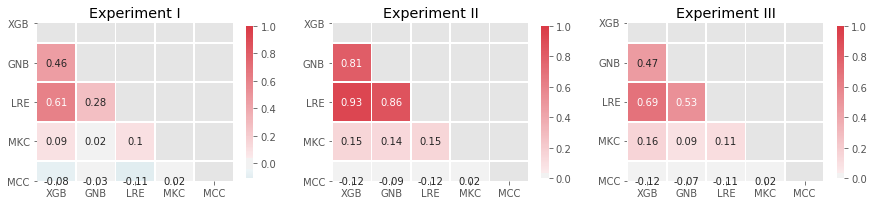

In [10]:
cols = [i for i in preds.columns if 'performance' in i]
temp = preds[cols] == 'y'
abvcols = list()
for i in cols:
    abvcols.append(classifier_abv[i.split("_")[0]])
temp.columns = abvcols
corr1 = temp.corr()
corr1 = round(corr1, 2)

cols = [i for i in preds.columns if 'market' in i]
temp = preds[cols] == 'y'
abvcols = list()
for i in cols:
    abvcols.append(classifier_abv[i.split("_")[0]])
temp.columns = abvcols
corr2 = temp.corr()
corr2 = round(corr2, 2)

cols = [i for i in preds.columns if 'total' in i]
temp = preds[cols] == 'y'
abvcols = list()
for i in cols:
    abvcols.append(classifier_abv[i.split("_")[0]])
temp.columns = abvcols
corr3 = temp.corr()
corr3 = round(corr3, 2)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axs = plt.subplots(ncols=3, figsize=(15,4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.yticks(rotation=0, fontsize="10", va="center")

sns.heatmap(corr1,cmap=cmap, mask=mask, vmax=1, center=0, annot=True,
            square=True, linewidths=.7, cbar_kws={"shrink": .7}, ax=axs[0]).set_title('Experiment I')

sns.heatmap(corr2, cmap=cmap, mask=mask, vmin=0, vmax=1, center=0, annot=True,
            square=True, linewidths=.7, cbar_kws={"shrink": .7}, ax=axs[1]).set_title('Experiment II')

sns.heatmap(corr3, cmap=cmap, mask=mask, vmin=0, vmax=1, center=0, annot=True,
            square=True, linewidths=.7, cbar_kws={"shrink": .7}, ax=axs[2]).set_title('Experiment III')

axs[0].tick_params(rotation=0)
axs[1].tick_params(rotation=0)
axs[2].tick_params(rotation=0)

plt.savefig('kappa.svg', bbox_inches='tight')
plt.show()



## Evolution of the performance of the classifiers in the beginning of the championship.

In [11]:
accs = pd.DataFrame()
for c in CLASSIFIERS:
    for e in EXPERIMENTS:
        acc = list()
            
        filename = 'test.csv'
        pred_dir = os.path.join(conf['path']['experiments'],'btts_v2', e[0], e[1], c, 'predictions')
        pred_file = os.path.join(pred_dir, filename)

        with open(pred_file, 'r') as outfile:
            data = pd.read_csv(outfile)
        
        data = data[data['m.odds.s.bts.y.t.avg'].notna()]
        data = data[data['m.odds.s.bts.n.t.avg'].notna()]
    
        for r in range(1,11):
            temp = data[data['m.rg'] >= r]
            score = round(accuracy_score(temp[RESULT], temp['pred']),3)
            acc.append(score)
            

        col = '_'.join([c,e[0]])
        accs[col] = acc

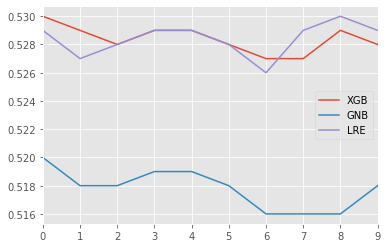

In [12]:
cols = [i for i in preds.columns if 'performance' in i]
temp = accs[cols]
abvcols = list()
for i in cols:
    abvcols.append(classifier_abv[i.split("_")[0]])
temp.columns = abvcols

temp[['XGB', 'GNB', 'LRE']].plot()
plt.savefig('round.svg', bbox_inches='tight')

plt.show()

# Profit/Loss

## Using AVG Odds

In [13]:
cols = [i for i in pl.columns if 'AVG' in i]
cols_exp1 = [i for i in cols if 'performance' in i]
cols_exp2 = [i for i in cols if 'market' in i]
cols_exp3 = [i for i in cols if 'total' in i]

display(pl[cols_exp1])
display(pl[cols_exp2])
display(pl[cols_exp3])

,performance_PR_AVG,performance_PR_AVG_ROI,performance_EV_AVG,performance_EV_AVG_ROI,performance_KC_AVG,performance_KC_AVG_ROI
XGBClassifier,-371.3560,-5.807882,-240.1512,-6.548983,-14.712465,-5.268444
GaussianNB,-309.3014,-4.837369,-255.8971,-4.320397,-66.910371,-3.501404
LogisticRegression,-439.5940,-6.875102,-214.7136,-6.063643,-16.740792,-6.275928
mkc,-575.1628,-5.997527,0.0000,NaN,0.000000,NaN
mcc,-524.4880,-5.469114,-524.4880,-5.469114,-524.488000,-5.914714


,market_PR_AVG,market_PR_AVG_ROI,market_EV_AVG,market_EV_AVG_ROI,market_KC_AVG,market_KC_AVG_ROI
XGBClassifier,-403.9765,-6.318056,-53.8599,-6.058481,-0.840665,-5.052554
GaussianNB,-419.7263,-6.564378,-361.6012,-6.110193,-190.953726,-7.561406
LogisticRegression,-399.9463,-6.255025,-6.6090,-17.392105,-0.004819,-0.519252
mkc,-575.1628,-5.997527,0.0000,NaN,0.000000,NaN
mcc,-524.4880,-5.469114,-524.4880,-5.469114,-524.488000,-5.914714


,total_PR_AVG,total_PR_AVG_ROI,total_EV_AVG,total_EV_AVG_ROI,total_KC_AVG,total_KC_AVG_ROI
XGBClassifier,-402.4091,-6.293542,-57.4799,-4.707609,-1.562783,-4.622137
GaussianNB,-331.4897,-5.184387,-327.6787,-5.350730,-184.904718,-5.379815
LogisticRegression,-375.0146,-5.865102,-167.0683,-7.600924,-9.174527,-7.771024
mkc,-575.1628,-5.997527,0.0000,NaN,0.000000,NaN
mcc,-524.4880,-5.469114,-524.4880,-5.469114,-524.488000,-5.914714


## Using MAX Odds

In [14]:
cols = [i for i in pl.columns if 'MAX' in i]
cols_exp1 = [i for i in cols if 'performance' in i]
cols_exp2 = [i for i in cols if 'market' in i]
cols_exp3 = [i for i in cols if 'total' in i]

display(pl[cols_exp1])
display(pl[cols_exp2])
display(pl[cols_exp3])

,performance_PR_MAX,performance_PR_MAX_ROI,performance_EV_MAX,performance_EV_MAX_ROI,performance_KC_MAX,performance_KC_MAX_ROI
XGBClassifier,-53.25,-0.832812,51.07,0.879910,6.968951,1.232162
GaussianNB,-6.47,-0.101189,34.41,0.545066,41.807850,1.886307
LogisticRegression,-124.12,-1.941195,-8.11,-0.141808,3.654563,0.672498
mkc,-119.72,-1.248384,88.41,1.824768,1.762705,1.985736
mcc,-87.80,-0.915537,-87.80,-0.915537,-87.800000,-0.943660


,market_PR_MAX,market_PR_MAX_ROI,market_EV_MAX,market_EV_MAX_ROI,market_KC_MAX,market_KC_MAX_ROI
XGBClassifier,-97.28,-1.521426,-25.27,-0.534249,3.756247,2.091915
GaussianNB,-106.19,-1.660776,-78.52,-1.252113,-39.124186,-1.374872
LogisticRegression,-95.11,-1.487488,37.84,1.079601,2.922891,3.222665
mkc,-119.72,-1.248384,88.41,1.824768,1.762705,1.985736
mcc,-87.80,-0.915537,-87.80,-0.915537,-87.800000,-0.943660


,total_PR_MAX,total_PR_MAX_ROI,total_EV_MAX,total_EV_MAX_ROI,total_KC_MAX,total_KC_MAX_ROI
XGBClassifier,-97.87,-1.530654,-61.04,-1.254676,2.297996,1.087725
GaussianNB,-24.94,-0.390053,-36.81,-0.582160,7.873622,0.210267
LogisticRegression,-68.67,-1.073976,5.66,0.106311,0.905601,0.270795
mkc,-119.72,-1.248384,88.41,1.824768,1.762705,1.985736
mcc,-87.80,-0.915537,-87.80,-0.915537,-87.800000,-0.943660


## Analysing Odds Levels

In [15]:
def get_matrix_pl(e, c, col):
    

    filename = 'test.csv'
        
    pred_dir = os.path.join(conf['path']['experiments'], 'btts_v2', e[0], e[1], c, 'predictions')
    pred_file = os.path.join(pred_dir, filename)

    with open(pred_file, 'r') as outfile:
        data = pd.read_csv(outfile)
        
    profit = pd.DataFrame()
    for i in range(30,71):
        for j in range(i,71):
            temp = data[data['m.odds.s.bts.y.t.avg'] >= i/100]
            temp = temp[temp['m.odds.s.bts.y.t.avg'] <= j/100]
            profit.loc[i/100, j/100] = temp[col].sum()

    return profit


def get_matrix_roi(e, c, col, bem=False):
    
    filename = 'test.csv'
        
    pred_dir = os.path.join(conf['path']['experiments'], 'btts_v2', e[0], e[1], c, 'predictions')
    pred_file = os.path.join(pred_dir, filename)

    with open(pred_file, 'r') as outfile:
        data = pd.read_csv(outfile)
        
    profit = pd.DataFrame()
    for i in range(30,71):
        for j in range(i,71):
            temp = data[data['m.odds.s.bts.y.t.avg'] >= i/100]
            temp = temp[temp['m.odds.s.bts.y.t.avg'] <= j/100]
            
            nmatches = len(temp)
            if nmatches > 100:
                if bem:
                    profit.loc[i/100, j/100] = temp[col].sum()/nmatches
                else:
                    profit.loc[i/100, j/100] = temp[col].sum()/temp[col].abs().sum()
            else:
                profit.loc[i/100, j/100] = 0

    return profit

#### Processing Profitability with AVG Odds (Ranges)

In [16]:
mats_pr_avg = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_PR_PL_AVG)
        col = "_".join([c,e[0]])
        mats_pr_avg[col] = mat

In [17]:
mats_ev_avg = dict()
for e in EXPERIMENTS:        
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_EV_PL_AVG)
        col = "_".join([c,e[0]])
        mats_ev_avg[col] = mat

In [18]:
mats_kc_avg = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_KC_PL_AVG)
        col = "_".join([c,e[0]])
        mats_kc_avg[col] = mat

#### Processing Profitability with MAX Odds (Ranges)

In [19]:
mats_pr_max = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_PR_PL_MAX)
        col = "_".join([c,e[0]])
        mats_pr_max[col] = mat

In [20]:
mats_ev_max = dict()
for e in EXPERIMENTS:        
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_EV_PL_MAX)
        col = "_".join([c,e[0]])
        mats_ev_max[col] = mat

In [21]:
mats_kc_max = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_pl(e, c, BET_KC_PL_MAX)
        col = "_".join([c,e[0]])
        mats_kc_max[col] = mat

#### Processing ROI with AVG Odds (Ranges)

In [22]:
mats_pr_avg_roi = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_roi(e, c, BET_PR_PL_AVG, True)
        col = "_".join([c,e[0]])
        mats_pr_avg_roi[col] = mat

In [23]:
mats_ev_avg_roi = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_roi(e, c, BET_EV_PL_AVG)
        col = "_".join([c,e[0]])
        mats_ev_avg_roi[col] = mat

/home/igormago/anaconda3/envs/DeepFootball/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


In [24]:
mats_kc_avg_roi = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_roi(e, c, BET_KC_PL_AVG)
        col = "_".join([c,e[0]])
        mats_kc_avg_roi[col] = mat

/home/igormago/anaconda3/envs/DeepFootball/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


#### Processing ROI with MAX Odds (Ranges)

In [25]:
mats_pr_max_roi = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_roi(e, c, BET_PR_PL_MAX, True)
        col = "_".join([c,e[0]])
        mats_pr_max_roi[col] = mat

In [26]:
mats_ev_max_roi = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_roi(e, c, BET_EV_PL_MAX)
        col = "_".join([c,e[0]])
        mats_ev_max_roi[col] = mat

In [27]:
mats_kc_max_roi = dict()
for e in EXPERIMENTS:
    for c in CLASSIFIERS:
        mat = get_matrix_roi(e, c, BET_KC_PL_MAX)
        col = "_".join([c,e[0]])
        mats_kc_max_roi[col] = mat

## Profitability per range

In [28]:
from mpl_toolkits.axes_grid1 import AxesGrid
def plot_heatmaps(mats):
    fig = plt.figure(figsize=(15,10))
    grid = AxesGrid(fig, 111,
                    nrows_ncols=(3, 5),
                    axes_pad=0.3,
                    cbar_location="right",
                    cbar_mode="single",
                    )

    for ax, m in zip(grid, mats):

        label = m.split('_')[0]
        hm = ax.imshow(mats[m])
        ax.set_title(label)
        ax.set_yticks([1,10,20,30,40])
        ax.set_xticks([1,10,20,30,40])
        ax.set_yticklabels([.3,.4,.5,.6,.7,.8])
        ax.set_xticklabels([.3,.4,.5,.6,.7,.8])

    cbar = grid.cbar_axes[0].colorbar(hm, ticks=np.arange(-200,200,10))
    plt.show()
    
    
def best_results(mats):
    
    res = list()
    for m in mats:
        df_temp = mats[m]
        mxv_rows = df_temp.max(axis=1)
        mxv_cols = df_temp.max(axis=0)

        idx_row = mxv_rows.idxmax()
        idx_col = mxv_cols.idxmax()
        val = mxv_rows.max()
        res.append([m, idx_row, idx_col, val])
        
    return pd.DataFrame(res)
        

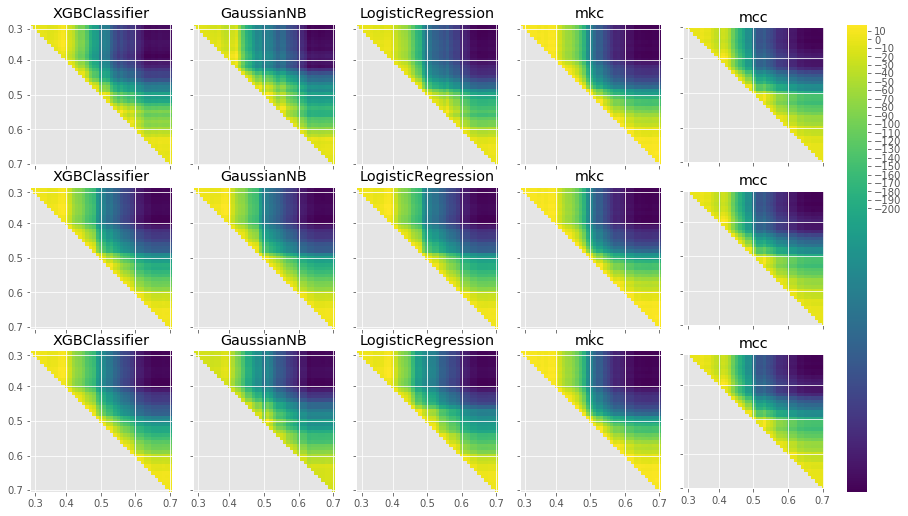

In [29]:
mats = mats_pr_avg
plot_heatmaps(mats)

In [30]:
mats = mats_pr_avg
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.35,0.39,14.4551
1,GaussianNB_performance,0.39,0.42,13.6780
2,LogisticRegression_performance,0.55,0.56,15.1305
3,mkc_performance,0.37,0.38,5.8264
4,mcc_performance,0.40,0.41,18.2779
5,XGBClassifier_market,0.35,0.39,9.4221
6,GaussianNB_market,0.35,0.39,9.4221
7,LogisticRegression_market,0.35,0.39,9.4221
8,mkc_market,0.37,0.38,5.8264
9,mcc_market,0.40,0.41,18.2779


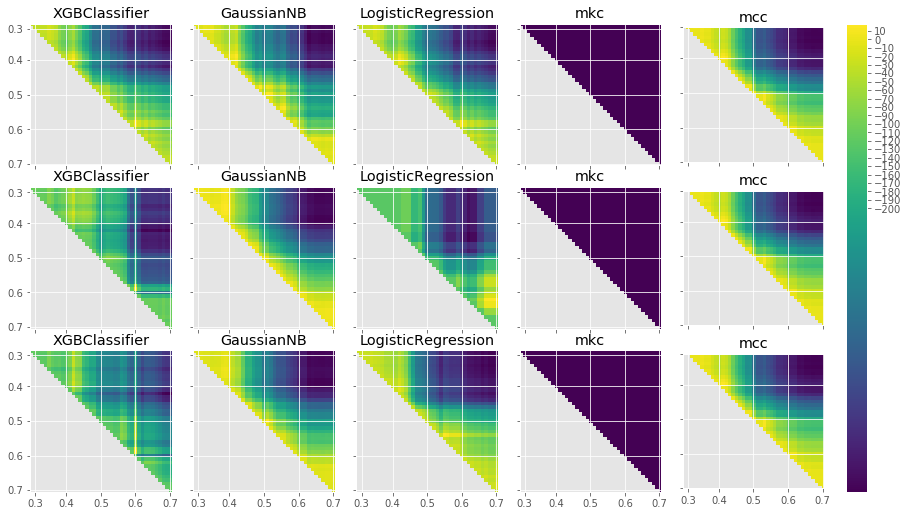

In [31]:
mats = mats_ev_avg
plot_heatmaps(mats)

In [32]:
mats = mats_ev_avg
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.40,0.42,25.4335
1,GaussianNB_performance,0.50,0.51,13.6140
2,LogisticRegression_performance,0.59,0.60,21.2905
3,mkc_performance,0.30,0.30,0.0000
4,mcc_performance,0.40,0.41,18.2779
5,XGBClassifier_market,0.59,0.60,19.1135
6,GaussianNB_market,0.35,0.39,9.4221
7,LogisticRegression_market,0.62,0.67,4.4604
8,mkc_market,0.30,0.30,0.0000
9,mcc_market,0.40,0.41,18.2779


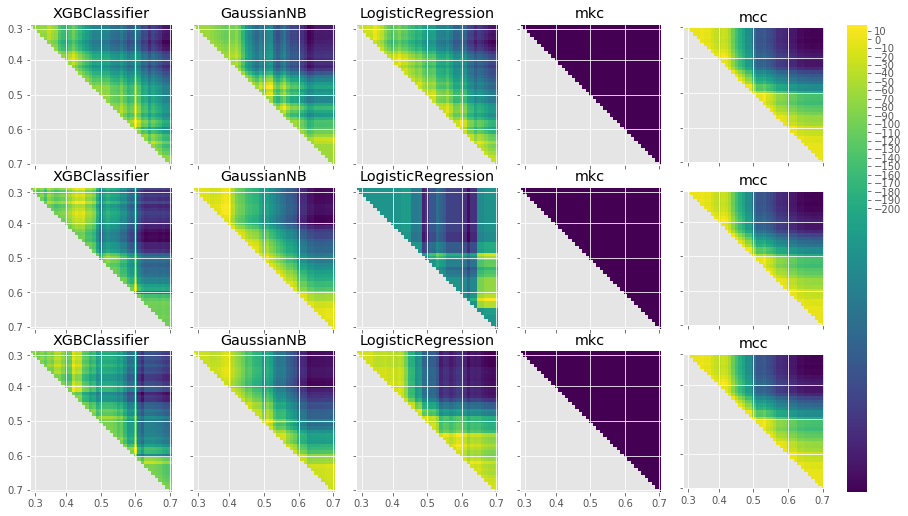

In [33]:
mats = mats_kc_avg
plot_heatmaps(mats)

In [34]:
mats = mats_kc_avg
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.58,0.60,2.905808
1,GaussianNB_performance,0.48,0.52,12.698755
2,LogisticRegression_performance,0.40,0.42,1.546916
3,mkc_performance,0.30,0.30,0.000000
4,mcc_performance,0.40,0.41,18.277900
5,XGBClassifier_market,0.34,0.43,0.264637
6,GaussianNB_market,0.35,0.39,9.348037
7,LogisticRegression_market,0.62,0.67,0.183480
8,mkc_market,0.30,0.30,0.000000
9,mcc_market,0.40,0.41,18.277900


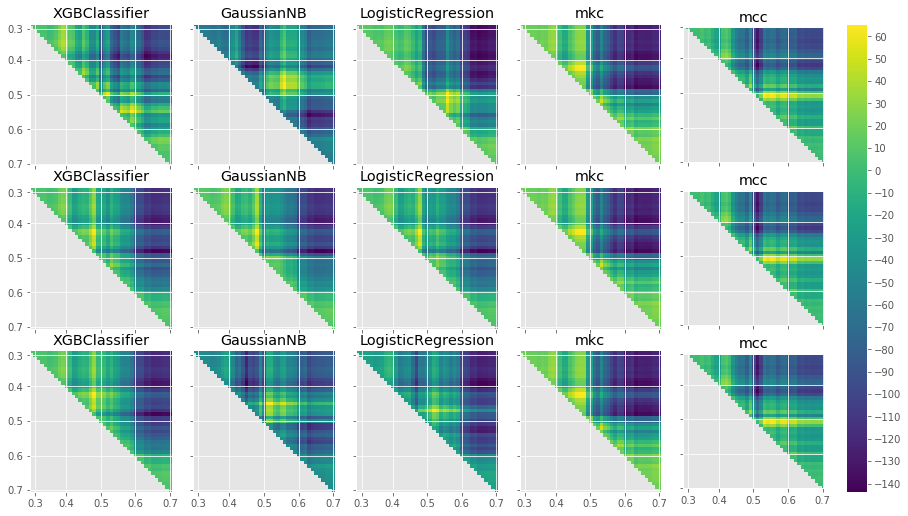

In [35]:
mats = mats_pr_max
plot_heatmaps(mats)

In [36]:
mats = mats_pr_max
best_results(mats)

,0,1,2,3
0,XGBClassifier_performance,0.55,0.59,34.60
1,GaussianNB_performance,0.47,0.56,88.26
2,LogisticRegression_performance,0.50,0.56,44.85
3,mkc_performance,0.42,0.48,38.95
4,mcc_performance,0.51,0.53,65.53
5,XGBClassifier_market,0.42,0.48,46.22
6,GaussianNB_market,0.42,0.48,46.46
7,LogisticRegression_market,0.42,0.48,46.51
8,mkc_market,0.42,0.48,38.95
9,mcc_market,0.51,0.53,65.53


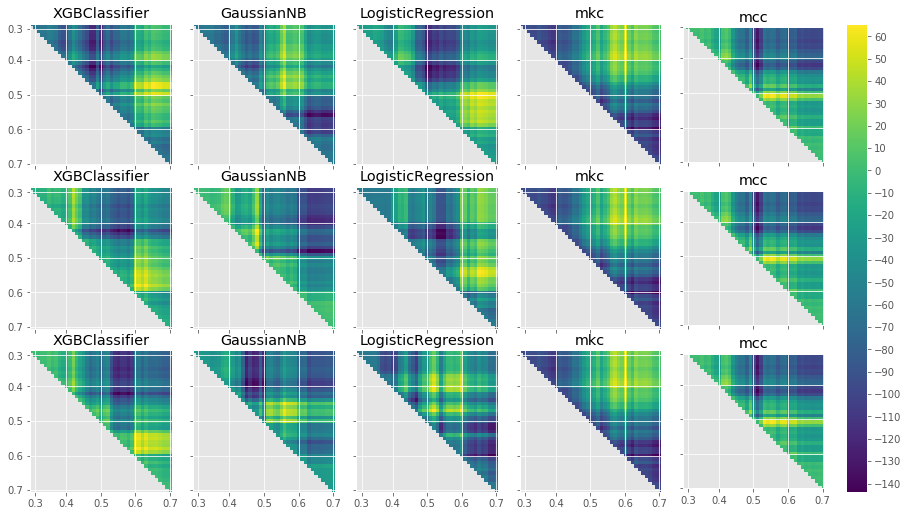

In [37]:
mats = mats_ev_max
plot_heatmaps(mats)

In [38]:
mats = mats_ev_max
best_results(mats)

,0,1,2,3
0,XGBClassifier_performance,0.48,0.65,110.04
1,GaussianNB_performance,0.47,0.56,110.91
2,LogisticRegression_performance,0.50,0.65,93.26
3,mkc_performance,0.39,0.60,140.43
4,mcc_performance,0.51,0.53,65.53
5,XGBClassifier_market,0.58,0.63,54.96
6,GaussianNB_market,0.42,0.48,49.86
7,LogisticRegression_market,0.54,0.65,65.43
8,mkc_market,0.39,0.60,140.43
9,mcc_market,0.51,0.53,65.53


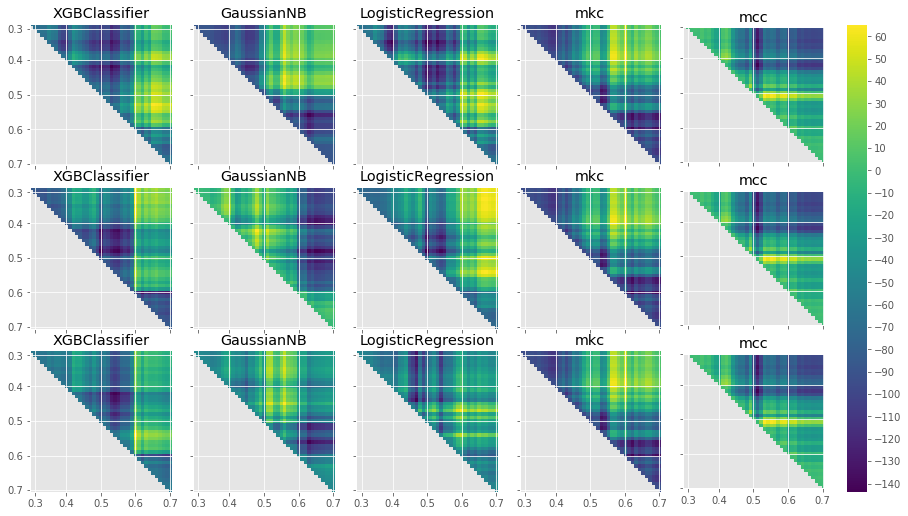

In [39]:
mats = mats_kc_max
plot_heatmaps(mats)

In [40]:
mats = mats_kc_max
best_results(mats)

,0,1,2,3
0,XGBClassifier_performance,0.53,0.65,13.314466
1,GaussianNB_performance,0.47,0.56,61.130862
2,LogisticRegression_performance,0.40,0.66,8.699905
3,mkc_performance,0.39,0.60,2.686369
4,mcc_performance,0.51,0.53,65.530000
5,XGBClassifier_market,0.34,0.60,4.810466
6,GaussianNB_market,0.42,0.48,27.353512
7,LogisticRegression_market,0.33,0.67,2.944978
8,mkc_market,0.39,0.60,2.686369
9,mcc_market,0.51,0.53,65.530000


## ROI per range

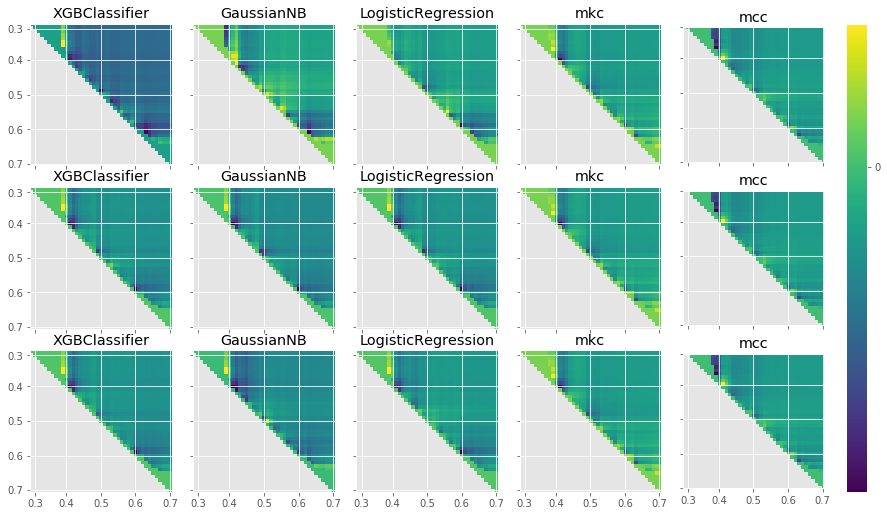

In [41]:
mats = mats_pr_avg_roi
plot_heatmaps(mats)

In [42]:
mats = mats_pr_avg_roi
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.35,0.39,0.118484
1,GaussianNB_performance,0.41,0.42,0.044087
2,LogisticRegression_performance,0.55,0.56,0.057750
3,mkc_performance,0.37,0.39,0.049357
4,mcc_performance,0.40,0.41,0.110108
5,XGBClassifier_market,0.35,0.39,0.077230
6,GaussianNB_market,0.35,0.39,0.077230
7,LogisticRegression_market,0.35,0.39,0.077230
8,mkc_market,0.37,0.39,0.049357
9,mcc_market,0.40,0.41,0.110108


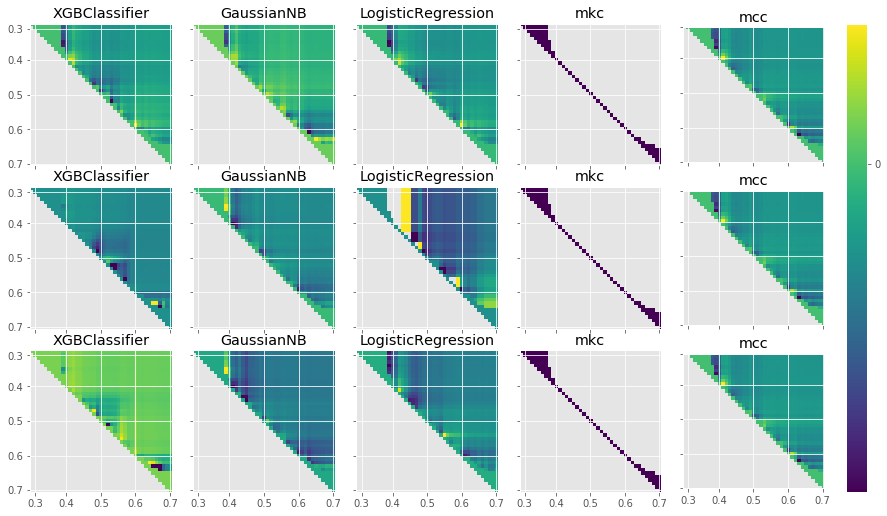

In [43]:
mats = mats_ev_avg_roi
plot_heatmaps(mats)

In [44]:
mats = mats_ev_avg_roi
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.59,0.60,0.121974
1,GaussianNB_performance,0.63,0.65,0.084964
2,LogisticRegression_performance,0.59,0.60,0.127267
3,mkc_performance,0.30,0.30,0.000000
4,mcc_performance,0.40,0.41,0.099187
5,XGBClassifier_market,0.63,0.65,1.000000
6,GaussianNB_market,0.35,0.39,0.121698
7,LogisticRegression_market,0.30,0.43,1.000000
8,mkc_market,0.30,0.30,0.000000
9,mcc_market,0.40,0.41,0.099187


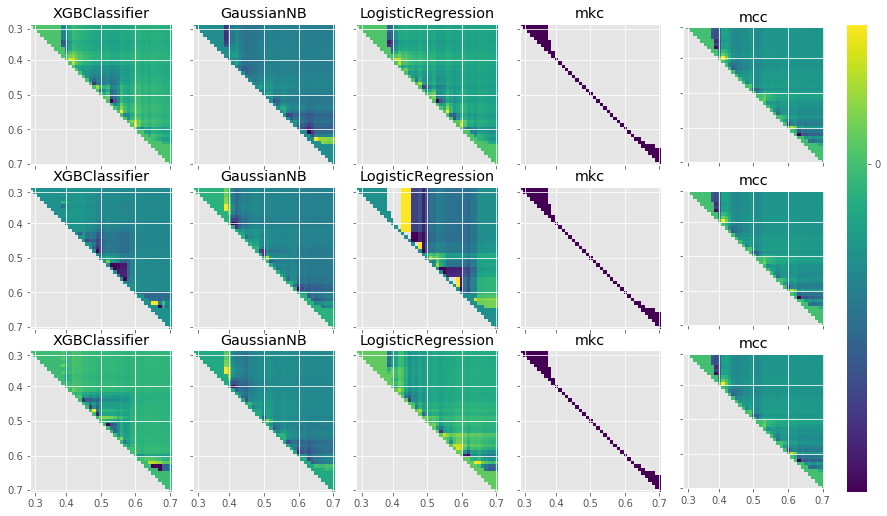

In [45]:
mats = mats_kc_avg_roi
plot_heatmaps(mats)

In [46]:
mats = mats_kc_avg_roi
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.55,0.56,0.144839
1,GaussianNB_performance,0.63,0.65,0.307046
2,LogisticRegression_performance,0.55,0.56,0.117423
3,mkc_performance,0.30,0.30,0.000000
4,mcc_performance,0.40,0.41,0.099187
5,XGBClassifier_market,0.63,0.65,1.000000
6,GaussianNB_market,0.35,0.39,0.135866
7,LogisticRegression_market,0.30,0.43,1.000000
8,mkc_market,0.30,0.30,0.000000
9,mcc_market,0.40,0.41,0.099187


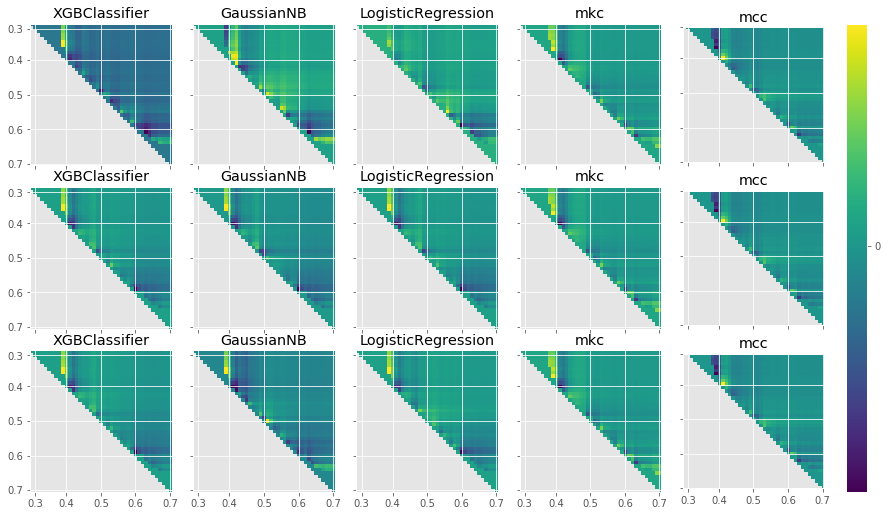

In [47]:
mats = mats_pr_max_roi
plot_heatmaps(mats)

In [48]:
mats = mats_pr_max_roi
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.35,0.39,0.180246
1,GaussianNB_performance,0.41,0.42,0.101656
2,LogisticRegression_performance,0.55,0.56,0.113626
3,mkc_performance,0.37,0.39,0.105913
4,mcc_performance,0.40,0.41,0.180361
5,XGBClassifier_market,0.35,0.39,0.135902
6,GaussianNB_market,0.35,0.39,0.135902
7,LogisticRegression_market,0.35,0.39,0.135902
8,mkc_market,0.37,0.39,0.105913
9,mcc_market,0.40,0.41,0.180361


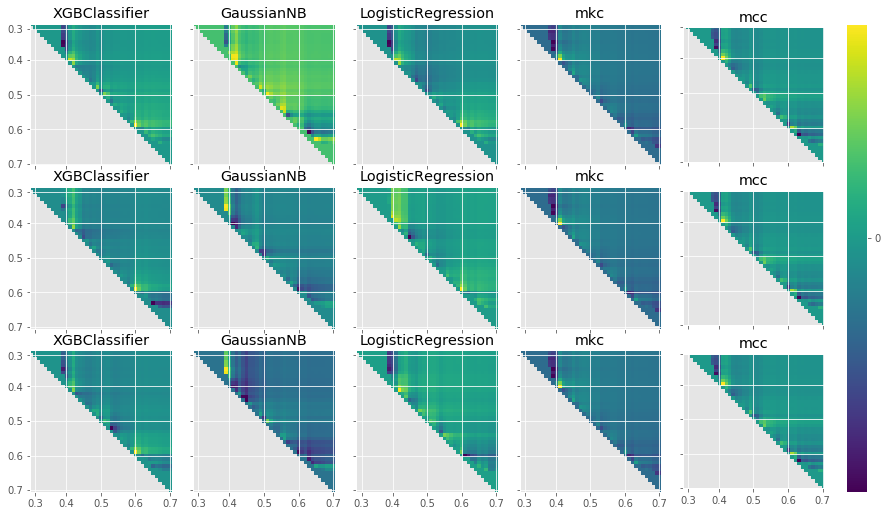

In [49]:
mats = mats_ev_max_roi
plot_heatmaps(mats)

In [50]:
mats = mats_ev_max_roi
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.59,0.60,0.194995
1,GaussianNB_performance,0.63,0.65,0.105529
2,LogisticRegression_performance,0.59,0.60,0.209447
3,mkc_performance,0.40,0.41,0.376902
4,mcc_performance,0.40,0.41,0.152802
5,XGBClassifier_market,0.59,0.60,0.199649
6,GaussianNB_market,0.35,0.39,0.196027
7,LogisticRegression_market,0.59,0.60,0.207944
8,mkc_market,0.40,0.41,0.376902
9,mcc_market,0.40,0.41,0.152802


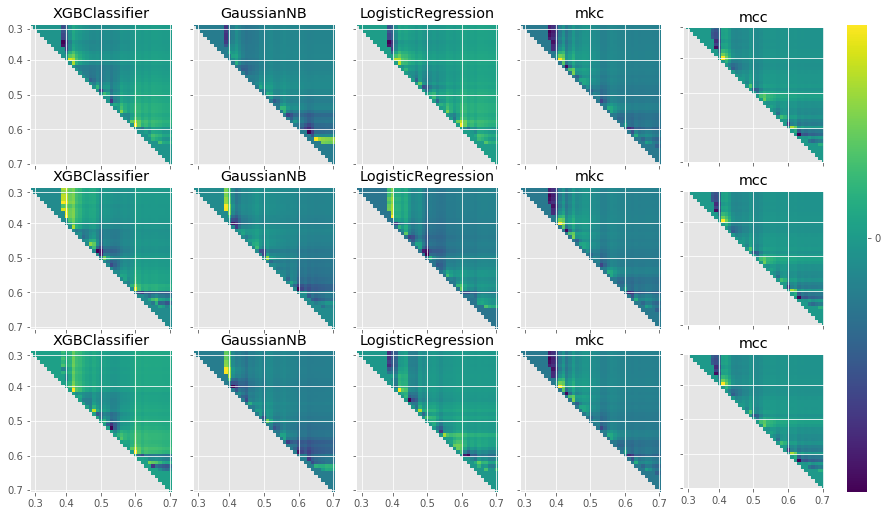

In [51]:
mats = mats_kc_max_roi
plot_heatmaps(mats)

In [52]:
mats = mats_kc_max_roi
display(best_results(mats))

,0,1,2,3
0,XGBClassifier_performance,0.59,0.60,0.198407
1,GaussianNB_performance,0.63,0.65,0.324763
2,LogisticRegression_performance,0.59,0.60,0.188382
3,mkc_performance,0.40,0.41,0.384742
4,mcc_performance,0.40,0.41,0.152802
5,XGBClassifier_market,0.34,0.39,0.191872
6,GaussianNB_market,0.35,0.39,0.208615
7,LogisticRegression_market,0.38,0.40,0.347030
8,mkc_market,0.40,0.41,0.384742
9,mcc_market,0.40,0.41,0.152802


## Summary of Best Classifiers (Profitability per range)

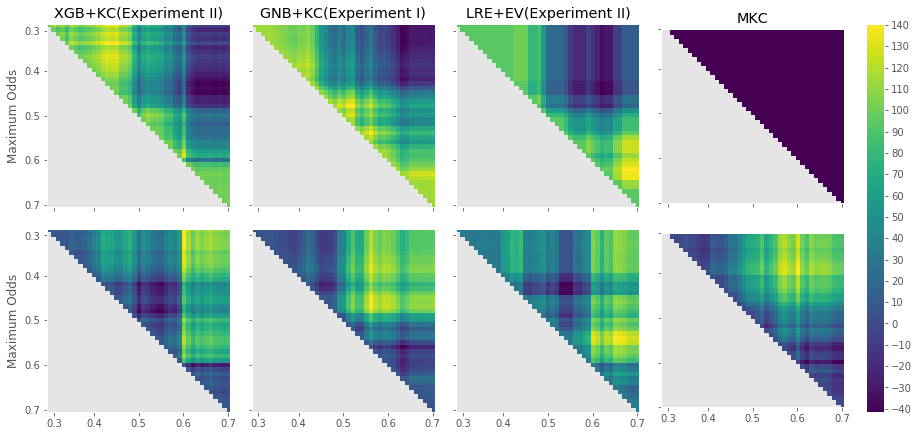

In [53]:
def plot_heatmaps_best(mats, titles):
    fig = plt.figure(figsize=(15,10))
    grid = AxesGrid(fig, 111,
                    nrows_ncols=(2, 4),
                    axes_pad=0.3,
                    cbar_location="right",
                    cbar_mode="single",
                    )

    i = 0
    for ax, m, label in zip(grid, mats, titles):

        hm = ax.imshow(mats[m])
        ax.set_title(label)
        ax.set_yticks([1,10,20,30,40])
        ax.set_xticks([1,10,20,30,40])
        ax.set_yticklabels([.3,.4,.5,.6,.7,.8])
        ax.set_xticklabels([.3,.4,.5,.6,.7,.8])
        
        if i == 1:
            ax.set_ylabel('Average Odds')
            i = i+1
        else:
            ax.set_ylabel('Maximum Odds')
        
        ax.grid(False)
            

    cbar = grid.cbar_axes[0].colorbar(hm, ticks=np.arange(-200,200,10))
    plt.savefig('heats.svg', bbox_inches='tight')
    plt.show()

selected = ['XGBClassifier_market_KC',
            'GaussianNB_performance_KC',
            'LogisticRegression_market_EV',
            'mkc_performance_EV' ]

titles=['XGB+KC(Experiment II)','GNB+KC(Experiment I)','LRE+EV(Experiment II)','MKC', '', '', '', '', '']
mats_best = dict()
mats_best['XGBClassifier_market_KC_avg'] = mats_kc_avg['XGBClassifier_market']
mats_best['GaussianNB_performance_KC_avg'] = mats_kc_avg['GaussianNB_performance']
mats_best['LogisticRegression_market_EV_avg'] = mats_ev_avg['LogisticRegression_market']
mats_best['mkc_performance_EV_avg'] = mats_ev_avg['mkc_market']
mats_best['XGBClassifier_market_KC_max'] = mats_kc_max['XGBClassifier_market']
mats_best['GaussianNB_performance_KC_max'] = mats_kc_max['GaussianNB_performance']
mats_best['LogisticRegression_market_EV_max'] = mats_ev_max['LogisticRegression_market']
mats_best['mkc_performance_EV_max'] = mats_ev_max['mkc_market']

plot_heatmaps_best(mats_best, titles=titles)

In [54]:
display(best_results(mats_best))

,0,1,2,3
0,XGBClassifier_market_KC_avg,0.34,0.43,0.264637
1,GaussianNB_performance_KC_avg,0.48,0.52,12.698755
2,LogisticRegression_market_EV_avg,0.62,0.67,4.460400
3,mkc_performance_EV_avg,0.30,0.30,0.000000
4,XGBClassifier_market_KC_max,0.34,0.60,4.810466
5,GaussianNB_performance_KC_max,0.47,0.56,61.130862
6,LogisticRegression_market_EV_max,0.54,0.65,65.430000
7,mkc_performance_EV_max,0.39,0.60,140.430000


In [55]:
print(mats_kc_avg_roi['XGBClassifier_market'].loc[0.42,0.48])
print(mats_kc_avg_roi['GaussianNB_performance'].loc[0.49,0.51])
print(mats_ev_avg_roi['LogisticRegression_market'].loc[0.50,0.65])
print(mats_kc_max_roi['XGBClassifier_market'].loc[0.54,0.57])
print(mats_kc_max_roi['GaussianNB_performance'].loc[0.40,0.56])
print(mats_ev_max_roi['LogisticRegression_market'].loc[0.45,0.48])
print(mats_ev_max_roi['mkc_market'].loc[0.39,0.60])


-0.09267815337036185
0.011553545827135673
-0.14913470156971803
0.02641799521714075
0.029930165360917103
0.010785746686154939
0.034269524453305535


In [56]:
mats_ev_avg['LogisticRegression_market']

,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.70
0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-11.2807,-12.2807,-11.8125,-11.8125,-9.6303,-9.6303,-7.8203,-7.8203,-7.8203,-7.8203
0.31,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-11.2807,-12.2807,-11.8125,-11.8125,-9.6303,-9.6303,-7.8203,-7.8203,-7.8203,-7.8203
0.32,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-11.2807,-12.2807,-11.8125,-11.8125,-9.6303,-9.6303,-7.8203,-7.8203,-7.8203,-7.8203
0.33,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-11.2807,-12.2807,-11.8125,-11.8125,-9.6303,-9.6303,-7.8203,-7.8203,-7.8203,-7.8203
0.34,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,-11.2807,-12.2807,-11.8125,-11.8125,-9.6303,-9.6303,-7.8203,-7.8203,-7.8203,-7.8203
0.35,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,-11.2807,-12.2807,-11.8125,-11.8125,-9.6303,-9.6303,-7.8203,-7.8203,-7.8203,-7.8203
0.36,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,-11.2807,-12.2807,-11.8125,-11.8125,-9.6303,-9.6303,-7.8203,-7.8203,-7.8203,-7.8203
0.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,-11.2807,-12.2807,-11.8125,-11.8125,-9.6303,-9.6303,-7.8203,-7.8203,-7.8203,-7.8203
0.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,-11.2807,-12.2807,-11.8125,-11.8125,-9.6303,-9.6303,-7.8203,-7.8203,-7.8203,-7.8203
0.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,-11.2807,-12.2807,-11.8125,-11.8125,-9.6303,-9.6303,-7.8203,-7.8203,-7.8203,-7.8203


## Generating Latex Tables

In [57]:
def get_scores_table(df, features, caption, label):
    
    countries = CHAMPIONSHIPS
    abvs = get_abv_list(countries)

    tab = ''
    tab += '\\begin{table*}[ht]' + '\n'
    tab += '\\small\\addtolength{\\tabcolsep}{-5pt}' + '\n'
    tab += '\\begin{tabularx}{\\textwidth}{C|CC|CC|CC|CC|CC|CC|CC|CC|CC|CC}' + '\n'

    tab += '\\toprule' + '\n'
    tab += '\\multirow{2}{*}{CLF} & '
    
    for a in abvs:
        tab += '\\multicolumn{2}{c|}{' +  a + '}' + ' & '
    tab += ' \\multicolumn{2}{c}{Total}' + ' \\\ \n'
    tab += '\\cline{2-21}' + '\n'

    tab += ' & '
    
    for a in abvs:
        tab += 'ACC & BRS & '
    
    tab += 'ACC & BRS' + ' \\\ \n'
    tab += '\\midrule' + '\n'

    for i, c in enumerate(CLASSIFIERS):
        sc = df[(df['features'] == features) & (df['classifier'] == c)]
        if i % 2 == 1:
            tab += '\\rowcolor{Gray} \n'
        tab += classifier_abv[str(sc['classifier'].values[0])]
        for ch in CHAMPIONSHIPS + ['total']:
            scc = sc[sc['championship'] == ch]
            tab += ' & ' + str(round(scc['acc'].values[0],3)) + ' & ' + str(round(scc['bsl'].values[0],3))
        tab += '\n \\\ \n'

    tab += '\\bottomrule' + '\n'
    tab += '\multicolumn{10}{c}{CLF: Classifier | ACC: Accuracy | BRS: Brier Score}'
    tab += '\\end{tabularx}' + '\n'
    tab += '\\caption{' + caption + '}\n'
    tab += '\\label{' + label + '}\n'
    tab += '\\end{table*}' + '\n'
    
    return tab

print(get_scores_table(scores, 'performance', 
                       caption='Classifier performances in Experiment I',
                       label='tab:scores1'))
print(get_scores_table(scores, 'market', 
                       caption='Classifier performances in Experiment II',
                       label='tab:scores2'))
print(get_scores_table(scores, 'total', 
                       caption='Classifier performances in Experiment III',
                       label='tab:scores3'))

\begin{table*}[ht]
\small\addtolength{\tabcolsep}{-5pt}
\begin{tabularx}{\textwidth}{C|CC|CC|CC|CC|CC|CC|CC|CC|CC|CC}
\toprule
\multirow{2}{*}{CLF} & \multicolumn{2}{c|}{BR1} & \multicolumn{2}{c|}{BR2} & \multicolumn{2}{c|}{GB1} & \multicolumn{2}{c|}{FR1} & \multicolumn{2}{c|}{DE1} & \multicolumn{2}{c|}{IT1} & \multicolumn{2}{c|}{NL1} & \multicolumn{2}{c|}{PT1} & \multicolumn{2}{c|}{ES1} &  \multicolumn{2}{c}{Total} \\ 
\cline{2-21}
 & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS & ACC & BRS \\ 
\midrule
XGB & 0.545 & 0.248 & 0.517 & 0.25 & 0.536 & 0.249 & 0.525 & 0.249 & 0.556 & 0.248 & 0.507 & 0.25 & 0.547 & 0.247 & 0.522 & 0.25 & 0.521 & 0.249 & 0.53 & 0.249
 \\ 
\rowcolor{Gray} 
GNB & 0.503 & 0.281 & 0.466 & 0.299 & 0.532 & 0.288 & 0.517 & 0.286 & 0.544 & 0.284 & 0.534 & 0.284 & 0.566 & 0.28 & 0.502 & 0.296 & 0.525 & 0.285 & 0.52 & 0.287
 \\ 
LRE & 0.545 & 0.247 & 0.529 & 0.25 & 0.517 & 0.251 & 0.53 & 0.249 & 0.539 & 0.24

In [58]:
def get_pl_table(label, caption):
    
    def highlight(value):
        value = round(value, 2)
        if value > 0:
            return '\\poscell ' + str(value)
        else:
            if math.isnan(value):
                return '0'
            return str(value)
            
    exps = ['performance', 'market','total']
    preds = ['PR', 'EV', 'KC']
    
    countries = CHAMPIONSHIPS
    abvs = get_abv_list(countries)

    tab = ''
    tab += '\\begin{table*}[ht]' + '\n'
    tab += '\\small\\addtolength{\\tabcolsep}{-8pt}' + '\n'
    tab += '\\begin{tabularx}{\\textwidth}{C|C|CC|CC|CC|CC|CC|CC}' + '\n'

    tab += '\\toprule' + '\n'
    tab += '\\multirow{3}{*}{CLF} & \multirow{3}{*}{BST} & '
    
    for i, a in enumerate(['Experiment I', 'Experiment II', 'Experiment III']):
        if i < 2:
            tab += '\\multicolumn{4}{c}{' +  a + '}' + ' & '
        else:
            tab += '\\multicolumn{4}{c|}{' +  a + '}'

    tab += '\\\ \\cline{3-14} & & '
    for i, a in enumerate(['AVG', 'MAX']*3):
        if i < 5:
            tab += '\\multicolumn{2}{c|}{' +  a + '}' + ' & '
        else:
            tab += '\\multicolumn{2}{c}{' +  a + '}'
        
    tab += '\\\ \\cline{3-14} & & '
    
    for i, a in enumerate(['AVG', 'MAX']*3):
        tab += 'PROF & ROI'
        if i < 5:
             tab+= ' & '

    tab += '\\\ \n\\midrule \n'

    for c in CLASSIFIERS:

        tab += '\\multirow{3}{*}{' + classifier_abv[c] + '}'
        sc = pl[pl.index == c]
        
        for p in preds:
            tab += ' & ' + p
            
            for e in exps: 
                tab += ' & '
                col_avg_v = '_'.join([e,p,'AVG'])
                col_max_v = '_'.join([e,p,'MAX'])
                
                col_avg_r = '_'.join([e,p,'AVG', 'ROI'])
                col_max_r = '_'.join([e,p,'MAX', 'ROI'])
                                
                if 'mkc' and 'avg' not in e[0]:
                    tab += highlight(sc[col_avg_v].values[0]) + ' & '   
                    tab += highlight(sc[col_avg_r].values[0]) + '\% & '
                    tab += highlight(sc[col_max_v].values[0]) + ' & '
                    tab += highlight(sc[col_max_r].values[0]) + '\% '
                else:
                    tab += 'N/A & '   
                    tab += 'N/A & '
                    tab += highlight(sc[col_max_v].values[0]) + ' & '
                    tab += highlight(sc[col_max_r].values[0]) + '\% '

                
            tab += '\\\ \n'
        tab += '\\hline \n'    
        
    tab += '\\bottomrule' + '\n'
    tab += '\\multicolumn{14}{c}{CLF:Classifier | BST: Betting Strategy | PROF: Profitability | AVG: Betting on the average odd | MAX: Betting on the maximum odd}' + '\n'
    tab += '\\end{tabularx}' + '\n'
    tab += '\\caption{' + caption + '}\n'
    tab += '\\label{' + label + '}\n'
    tab += '\\end{table*}' + '\n'
    
    return tab

print(get_pl_table(caption='Profitability and ROI of Classifiers', label='tab:profitability'))

\begin{table*}[ht]
\small\addtolength{\tabcolsep}{-8pt}
\begin{tabularx}{\textwidth}{C|C|CC|CC|CC|CC|CC|CC}
\toprule
\multirow{3}{*}{CLF} & \multirow{3}{*}{BST} & \multicolumn{4}{c}{Experiment I} & \multicolumn{4}{c}{Experiment II} & \multicolumn{4}{c|}{Experiment III}\\ \cline{3-14} & & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c|}{MAX} & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c|}{MAX} & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c}{MAX}\\ \cline{3-14} & & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI\\ 
\midrule 
\multirow{3}{*}{XGB} & PR & -371.36 & -5.81\% & -53.25 & -0.83\%  & -403.98 & -6.32\% & -97.28 & -1.52\%  & -402.41 & -6.29\% & -97.87 & -1.53\% \\ 
 & EV & -240.15 & -6.55\% & \poscell 51.07 & \poscell 0.88\%  & -53.86 & -6.06\% & -25.27 & -0.53\%  & -57.48 & -4.71\% & -61.04 & -1.25\% \\ 
 & KC & -14.71 & -5.27\% & \poscell 6.97 & \poscell 1.23\%  & -0.84 & -5.05\% & \poscell 3.76 & \poscell 2.09\%  & -1.56 & -4.62\% & \poscell 2.3 & \pos

In [59]:
def get_pl_table(label, caption):
    
    def highlight(value):
        value = round(value, 2)
        if value > 0:
            return '\\poscell' + str(value)
        else:
            if math.isnan(value):
                return '0'
            return str(value)
            
    selected = ['XGBClassifier_market_KC',
                'GaussianNB_performance_KC',
                'LogisticRegression_market_EV',
                'mkc_performance_EV' ]
    
    
    countries = CHAMPIONSHIPS
    abvs = get_abv_list(countries)

    tab = ''
    tab += '\\begin{table*}[ht]' + '\n'
    tab += '\\small\\addtolength{\\tabcolsep}{-8pt}' + '\n'
    tab += '\\begin{tabularx}{\\textwidth}{C|CC|CC|CC|CC|CC|CC|CC|CC}' + '\n'

    tab += '\\toprule' + '\n'
    tab += '\\multirow{3}{*}{CH} & '
    
    for i, a in enumerate(['XGB+KC (Experiment II)', 'GNB+KC (Experiment I)', 'LRE+EV (Experiment II)', 'MKC+EV']):
        if i < 3:
            tab += '\\multicolumn{4}{c|}{' +  a + '}' + ' & '
        else:
            tab += '\\multicolumn{4}{c}{' +  a + '}' + ' \n '

    tab += '\\\ \\cline{2-17} & '
    for i, a in enumerate(['AVG', 'MAX']*4):
        if i < 7:
            tab += '\\multicolumn{2}{c|}{' +  a + '}' + ' & '
        else:
            tab += '\\multicolumn{2}{c}{' +  a + '}' + ' \n '

    tab += '\\\ \\cline{2-17} & '
    
    for i, a in enumerate(['AVG', 'MAX']*4):
        tab += 'PROF & ROI'
        if i < 7:
            tab+= ' & '

    tab += '\\\ \n\\midrule \n'

    for c in countries:
        
        tab += countries_abv[c]
        sc = pl_champ[pl_champ.index == c]

        for e in selected:

            tab += ' & '
            col_avg_v = '_'.join([e,'AVG'])
            col_max_v = '_'.join([e,'MAX'])

            col_avg_r = '_'.join([e,'AVG', 'ROI'])
            col_max_r = '_'.join([e,'MAX', 'ROI'])

            tab += highlight(sc[col_avg_v].values[0]) + ' & '   
            tab += highlight(sc[col_avg_r].values[0]) + '\% & '
            tab += highlight(sc[col_max_v].values[0]) + ' & '
            tab += highlight(sc[col_max_r].values[0]) + '\% '


        tab += '\\\ \\hline \n'    
        
    tab += '\\bottomrule' + '\n'
    tab += '\\multicolumn{17}{c}{CH:Championship | PROF: Profitability | AVG: Betting on the average odd | MAX: Betting on the maximum odd}' + '\n'
    tab += '\\end{tabularx}' + '\n'
    tab += '\\caption{' + caption + '}\n'
    tab += '\\label{' + label + '}\n'
    tab += '\\end{table*}' + '\n'
    
    return tab

print(get_pl_table(caption='Profitability and ROI of best classifiers per championship', label='tab:prof_by_champ'))

\begin{table*}[ht]
\small\addtolength{\tabcolsep}{-8pt}
\begin{tabularx}{\textwidth}{C|CC|CC|CC|CC|CC|CC|CC|CC}
\toprule
\multirow{3}{*}{CH} & \multicolumn{4}{c|}{XGB+KC (Experiment II)} & \multicolumn{4}{c|}{GNB+KC (Experiment I)} & \multicolumn{4}{c|}{LRE+EV (Experiment II)} & \multicolumn{4}{c}{MKC+EV} 
 \\ \cline{2-17} & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c|}{MAX} & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c|}{MAX} & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c|}{MAX} & \multicolumn{2}{c|}{AVG} & \multicolumn{2}{c}{MAX} 
 \\ \cline{2-17} & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI & PROF & ROI\\ 
\midrule 
BR1 & \poscell0.65 & \poscell34.21\% & \poscell0.61 & \poscell4.89\%  & -3.93 & -1.64\% & \poscell9.67 & \poscell3.52\%  & -1.0 & -100.0\% & -6.01 & -2.62\%  & 0.0 & 0\% & -1.14 & -0.4\% \\ \hline 
BR2 & \poscell0.04 & \poscell4.45\% & \poscell1.14 & \poscell9.11\%  & -15.92 & -6.04\% & -3.26 & -1.09\%  & -0.16 & -7.9\% & \